## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_दिल्ली WIND SPEED_

In [3]:
data = pd.read_csv("datasets/delhi.csv")
training_set = data.iloc[:, 3]
print(training_set)

0       0.000000
1       2.980000
2       4.633333
3       1.233333
4       3.700000
          ...   
1457    3.547826
1458    6.000000
1459    6.266667
1460    7.325000
1461    0.000000
Name: wind_speed, Length: 1462, dtype: float64


## Preprocessing the Data

In [4]:
# Multivariate data preparation
from numpy import array

# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[ 0.          2.98        4.63333333  1.23333333  3.7         1.48
  6.3         7.14285714 12.5         7.4       ] [10.57142857 13.22857143  4.63333333  0.61666667  0.52857143  0.
  5.25        8.95        5.88333333  8.47142857  2.22        3.08333333
  4.01666667  6.16666667  5.55        6.8         5.55714286  3.7
  3.2375      1.05714286  2.96        2.22        1.32857143  1.85714286
 11.11428571  9.725       8.63333333 10.74        9.25714286  9.25714286
  3.475       5.325       7.41666667  6.08571429  4.33333333 10.18333333
  8.48571429  0.         12.22        5.81428571  5.81428571  6.61428571
 10.875       9.25714286  7.4         4.6375     17.5875      6.66
 12.95714286 24.06666667 15.725       8.63333333]
[ 2.98        4.63333333  1.23333333  3.7         1.48        6.3
  7.14285714 12.5         7.4        10.57142857] [13.22857143  4.63333333  0.61666667  0.52857143  0.          5.25
  8.95        5.88333333  8.47142857  2.22        3.08333333  4.01666667
  6.16666667  

## Train and Test Split

In [5]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1120, 1, 10) (1120, 52) (281, 1, 10) (281, 52)


## Model (Without Monte Carlo Dropout)

In [6]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
17/17 [==============================] - 2s 36ms/step - loss: 65.2509 - val_loss: 63.6184
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 58.4088 - val_loss: 54.1891


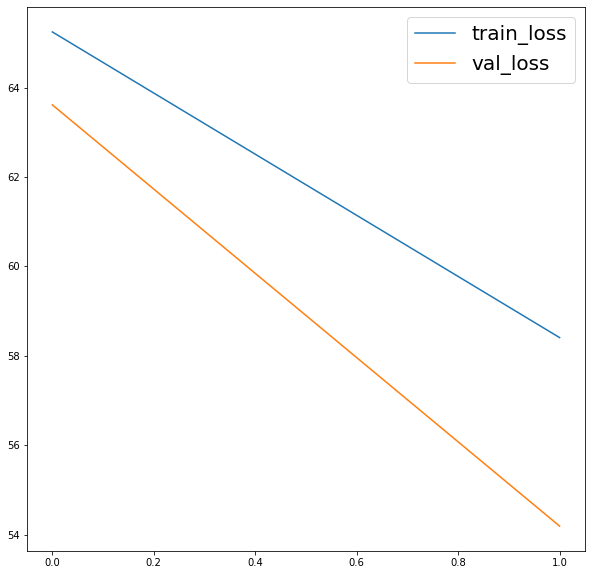

In [7]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]*10))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

11/11 [==============================] - 0s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 6.772
Test MAE: 5.514


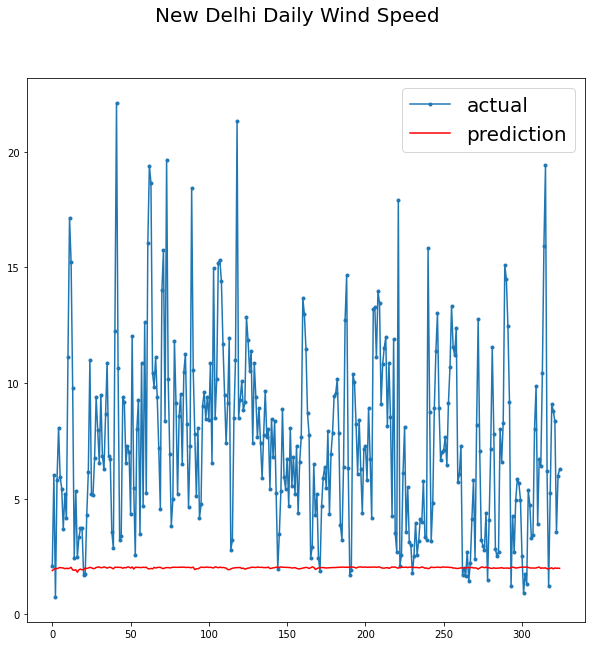

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('New Delhi Daily Wind Speed', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [10]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [11]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.add(MCDropout(0.4))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
17/17 [==============================] - 2s 31ms/step - loss: 64.9011 - val_loss: 63.5795
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 58.6912 - val_loss: 54.8497


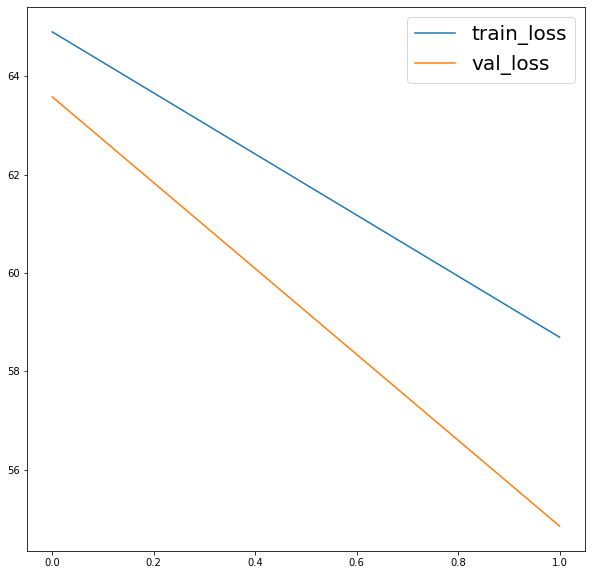

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]*10))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

11/11 [==============================] - 0s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 8.062
Test MAE: 6.997


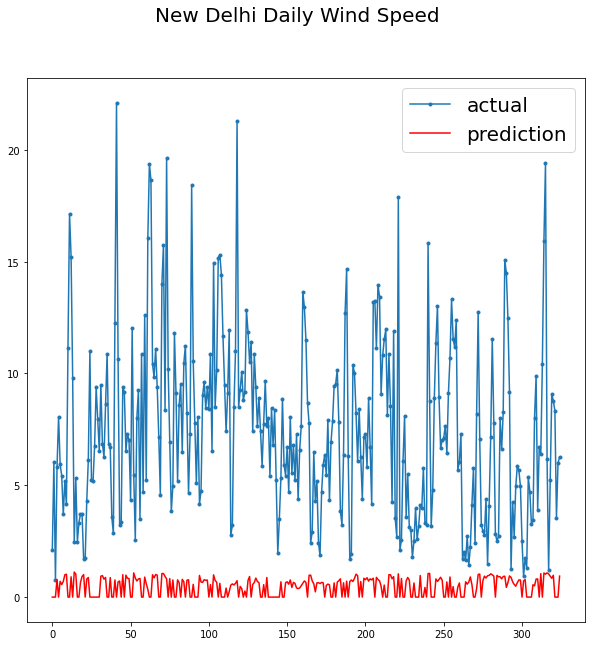

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('New Delhi Daily Wind Speed', fontsize=20)
plt.legend(fontsize=20)
plt.show()